In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

In [2]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:30999/nam/data/nam_s')
df.take(1)

CPU times: user 73.3 ms, sys: 26.2 ms, total: 99.5 ms
Wall time: 5min 51s


In [3]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    [ "direct_evaporation_cease_soil_moisture_surface", 
         "precipitable_water_entire_atmosphere", 
         "soil_porosity_surface",
        "direct_evaporation_cease_soil_moisture_surface"],
    "vegetation_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.06624999642372...|95.75|
|(4,[1],[20.392850...|  0.0|
|[0.02749999985098...|86.25|
|(4,[1],[55.483531...|  0.0|
|[0.04749999940395...|41.25|
|(4,[1],[27.725078...|  0.0|
|[0.13499999046325...| 64.5|
|(4,[1],[17.061397...|  0.0|
|(4,[1],[23.348155...|  0.0|
|(4,[1],[53.529350...|  0.0|
|(4,[1],[39.825428...|  0.0|
|(4,[1],[26.067039...|  0.0|
|[0.04749999940395...| 77.0|
|(4,[1],[26.277297...|  0.0|
|(4,[1],[25.827457...|  0.0|
|[0.06624999642372...|43.25|
|[0.06624999642372...| 58.0|
|(4,[1],[53.584957...|  0.0|
|(4,[1],[53.376407...|  0.0|
|(4,[1],[54.270172...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [4]:
%%time 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 14.0523
CPU times: user 411 ms, sys: 188 ms, total: 599 ms
Wall time: 36min 4s


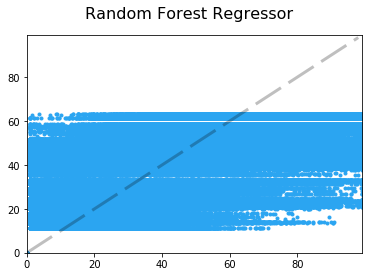

In [7]:
import matplotlib.pyplot as plt
pdf = predictions.sample(False, 0.1)
p_df = pdf.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()